
# Introduction 

![](https://storage.googleapis.com/kaggle-datasets-images/1209633/2021025/67b9223181141133207afc36e35e3c5d/dataset-cover.jpg?t=2021-03-14-15-48-53)

### About Dataset

* **Breast cancer** is one of the **most common** causes of death among **women worldwide**. Early detection helps in reducing the **number of early deaths**. The data reviews the **medical images of breast cancer** using ultrasound scan. **Breast Ultrasound Dataset** is categorized into **three classes** $:$ **normal, benign, and malignant images**. **Breast ultrasound images** can produce great results in **classification, detection, and segmentation** of breast cancer when combined with machine learning. 

* The data collected at baseline include **breast ultrasound images among women** in ages between 25 and 75 years old. This data was collected in **2018**. The number of patients is **600 female patients**. The dataset consists of **780 images** with an **average image size of 500*500 pixels**. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into **three classes, which are normal, benign, and malignant**.

## What is U-Net?

- **U-Net** is a popular deep-learning **architecture for semantic segmentation**. Originally developed for **medical images**, it had great success in this field. But, that was only the beginning! From satellite images to handwritten characters, the architecture has improved performance on a range of data types.
- The **U-Net architecture** has been widely used in various medical image segmentation tasks, such as **brain tumor segmentation, lung segmentation, and cell segmentation**, among others.

### U-Net: Convolutional Networks for Biomedical Image Segmentation

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

- U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.

- This illustration is an example of Unet architecture but layers can have different size.

**We apply it for breast cancer image segmentation with some modifications to the model.**

In [1]:
# Common
import tensorflow as tf
from glob import glob
import numpy as np

# Data
from sklearn.model_selection import train_test_split
import cv2

# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

# Metrics
from tensorflow.keras.metrics import *


##  Exploring data : 

In [2]:
paths = glob('../AII/Dataset_BUSI_with_GT/*/*')

print(f'\033[92m')
print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")


'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


In [3]:
sorted(glob('../AII/Dataset_BUSI_with_GT/*/*'))[4:7]

['../AII/Dataset_BUSI_with_GT\\benign\\benign (100).png',
 '../AII/Dataset_BUSI_with_GT\\benign\\benign (100)_mask.png',
 '../AII/Dataset_BUSI_with_GT\\benign\\benign (100)_mask_1.png']

*** Some images have 2 or more masks. Combine them into one image.**


##  Loading data 

Functions

In [4]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []
    
    x = 0   # additional variable to identify images consisting of 2 or more masks
    
    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image
            
        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask
                    
                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [7]:
size = 128   # image size: 128x128
X, y = load_data( '../AII/Dataset_BUSI_with_GT/*/*', size)

## Data of each class 

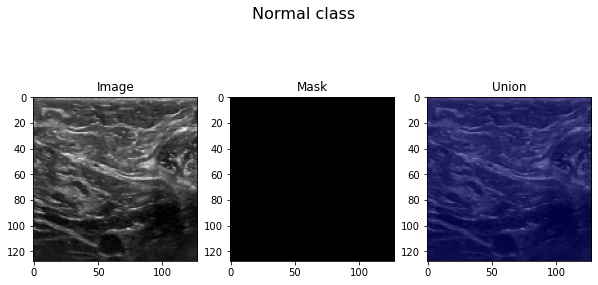

In [8]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

# X[0:437] benign
# X[437:647] malignant
# X[647:780] normal

i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

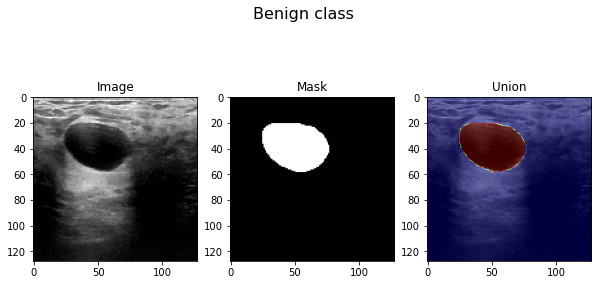

In [9]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

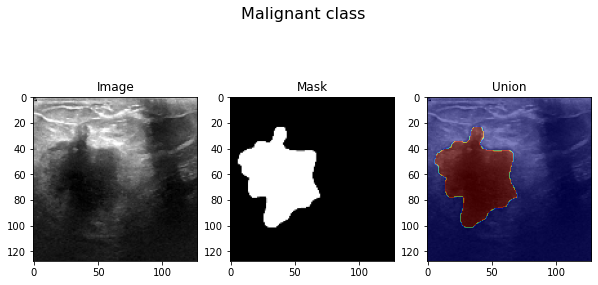

In [10]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()


##  Average view of masks each class 

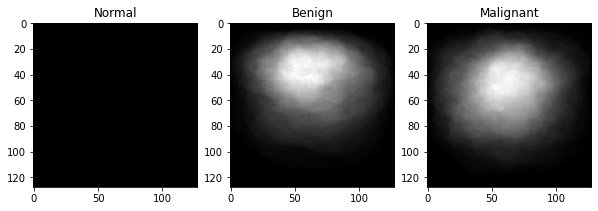

In [11]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(sum(y[647:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y[:437]), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(y[437:647]), cmap='gray')
ax[2].set_title('Malignant')
plt.show()

# data preprocessing

###  Prepare data to modeling 

In [12]:
# drop normal class because normal class has not mask
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


### Train-test split 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (582, 128, 128, 1)
y_train shape: (582, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_test shape: (65, 128, 128, 1)



## Building U-Net Architecture 

###  Conv block 

In [14]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

### Encoder block 

In [15]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

### Decoder block 

In [16]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

###  Build model 

In [17]:
def build_model(input_shape):
    input_layer = Input(input_shape)
    
    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

###  Model plotting 

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


###  Model summary

In [21]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             


## training

In [22]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test,y_test))

Epoch 1/100
19/19 [==============================] - 229s 12s/step - loss: 0.4892 - accuracy: 0.8556 - val_loss: 0.3068 - val_accuracy: 0.9167
Epoch 2/100
19/19 [==============================] - 226s 12s/step - loss: 0.3141 - accuracy: 0.9035 - val_loss: 0.2403 - val_accuracy: 0.9173
Epoch 3/100
19/19 [==============================] - 229s 12s/step - loss: 0.3014 - accuracy: 0.8942 - val_loss: 0.2091 - val_accuracy: 0.9167
Epoch 4/100
19/19 [==============================] - 233s 12s/step - loss: 0.2259 - accuracy: 0.9033 - val_loss: 0.1976 - val_accuracy: 0.9208
Epoch 5/100
19/19 [==============================] - 230s 12s/step - loss: 0.2132 - accuracy: 0.9153 - val_loss: 0.1874 - val_accuracy: 0.9313
Epoch 6/100
19/19 [==============================] - 230s 12s/step - loss: 0.2005 - accuracy: 0.9208 - val_loss: 0.1831 - val_accuracy: 0.9323
Epoch 7/100
19/19 [==============================] - 231s 12s/step - loss: 0.1985 - accuracy: 0.9192 - val_loss: 0.1855 - val_accuracy: 0.9218

Epoch 58/100
19/19 [==============================] - 230s 12s/step - loss: 0.0402 - accuracy: 0.9844 - val_loss: 0.1820 - val_accuracy: 0.9541
Epoch 59/100
19/19 [==============================] - 229s 12s/step - loss: 0.0316 - accuracy: 0.9856 - val_loss: 0.1748 - val_accuracy: 0.9557
Epoch 60/100
19/19 [==============================] - 229s 12s/step - loss: 0.0352 - accuracy: 0.9846 - val_loss: 0.1370 - val_accuracy: 0.9620
Epoch 61/100
19/19 [==============================] - 229s 12s/step - loss: 0.0401 - accuracy: 0.9823 - val_loss: 0.1750 - val_accuracy: 0.9583
Epoch 62/100
19/19 [==============================] - 228s 12s/step - loss: 0.0269 - accuracy: 0.9869 - val_loss: 0.2664 - val_accuracy: 0.9616
Epoch 63/100
19/19 [==============================] - 229s 12s/step - loss: 0.0245 - accuracy: 0.9888 - val_loss: 0.1904 - val_accuracy: 0.9594
Epoch 64/100
19/19 [==============================] - 229s 12s/step - loss: 0.0212 - accuracy: 0.9900 - val_loss: 0.1931 - val_accuracy:

In [23]:
model.save_weights('model_weights.h5')


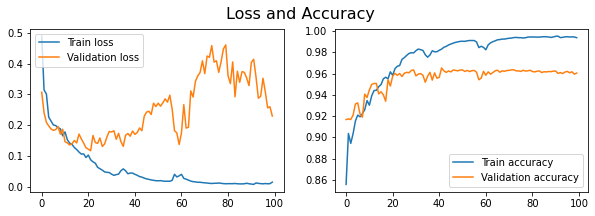

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

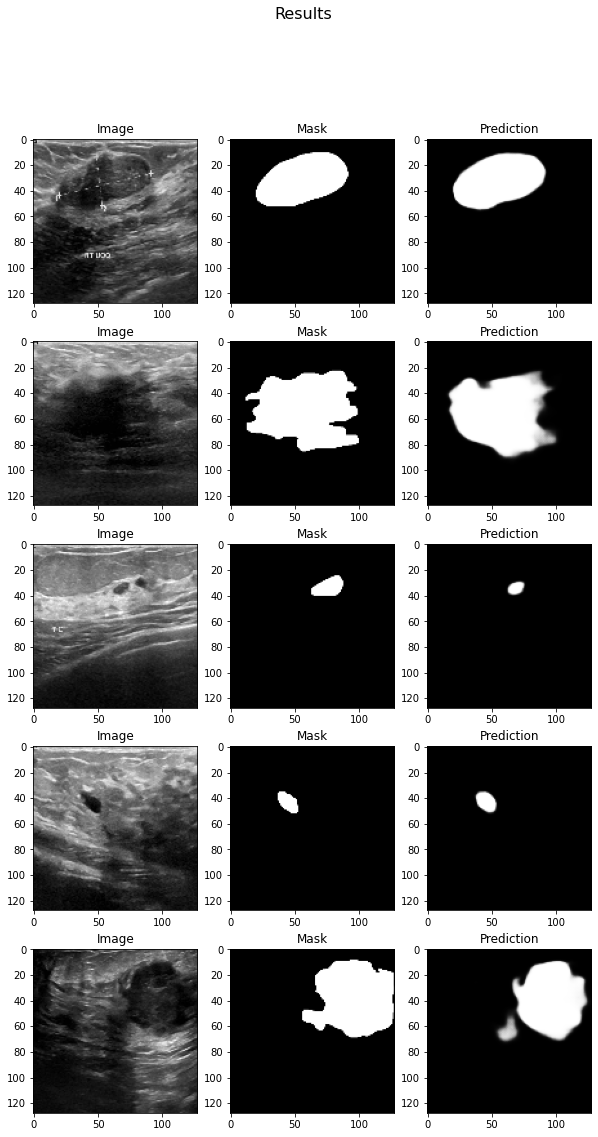

In [25]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

In [26]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)


Mean IoU = 0.78645235
Precision Score = 0.746
Recall Score = 0.778
F1 Score = 0.762
